In [2]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.utils as utils
from   tensorflow.keras.preprocessing.image import ImageDataGenerator
from   tensorflow.keras.models import Sequential
from   tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, ZeroPadding2D
from   tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from   tensorflow.keras.utils import plot_model
from   tensorflow.keras.callbacks import ModelCheckpoint
from   pathlib import Path
from   tensorflow.keras import models, layers, optimizers
from   sklearn.utils.class_weight import compute_class_weight


In [3]:
warnings.filterwarnings("ignore")

In [4]:
data_path = 'trash_images'

In [5]:
# Data Classes
print(os.listdir(data_path))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [6]:
main_folder_path = Path(data_path)

all_folders = [d for d in main_folder_path.glob('**/') if d.is_dir()]

# Count number of files in each class
data = [] 
for folder in all_folders:
    folder_name = folder.name
    file_count = len(list(folder.glob('*.*')))
    if folder_name != data_path: 
        data.append({'Folder Name': folder_name, 'File Count': file_count})

count = pd.DataFrame(data)

count = count.set_index('Folder Name')
count

,File Count
Folder Name,
cardboard,403
glass,501
metal,410
paper,594
plastic,482
trash,137


In [7]:
print(f'Total {count.sum()}')

Total File Count    2527
dtype: int64


In [8]:
# Show five image of each class
def plot_imgs(item_dir, top=10):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:5]
  
    plt.figure(figsize=(10, 10))
  
    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)
    
        img = plt.imread(img_path)
        plt.tight_layout()         
        plt.imshow(img, cmap='gray') 
        plt.axis('off')
        plt.title(os.path.basename(item_dir)) 

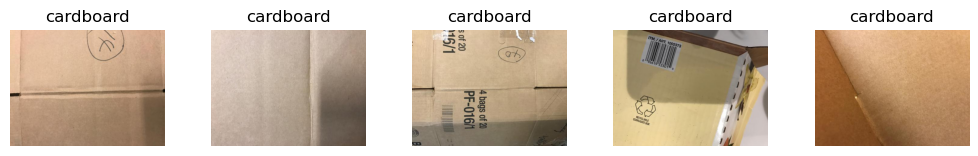

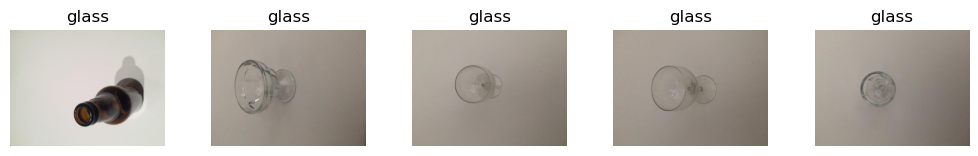

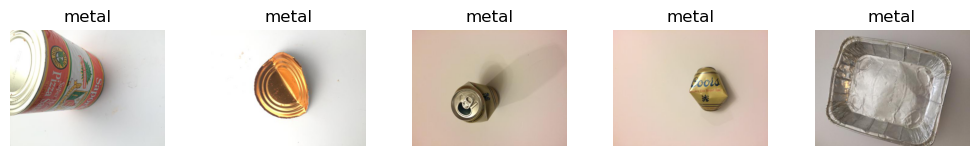

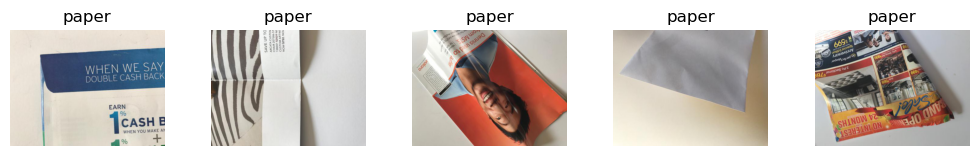

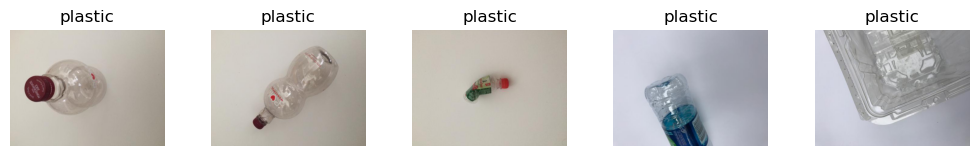

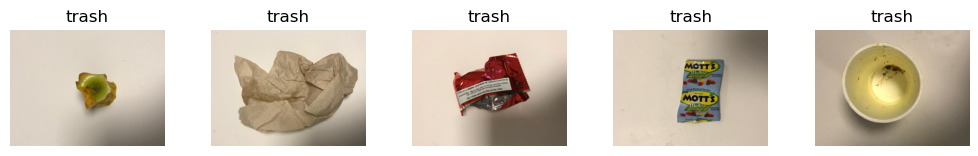

In [9]:
plot_imgs(data_path+'/cardboard')
plot_imgs(data_path+'/glass')
plot_imgs(data_path+'/metal')
plot_imgs(data_path+'/paper')
plot_imgs(data_path+'/plastic')
plot_imgs(data_path+'/trash')

In [10]:
# Define variable for requirements
batch_size = 30
target_size = (180, 180)
validation_split = 0.15

In [11]:
# Data Generators
train_img_generator = ImageDataGenerator(rescale=1./255,
                                         validation_split=validation_split,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         zoom_range = 0.5,
                                         width_shift_range = 0.3,
                                         height_shift_range = 0.3,
                                         rotation_range=50,
                                         shear_range = 0.3,
                                         fill_mode='nearest'
                                        )

test_data_img_generator = ImageDataGenerator(rescale=1./255,
                                             validation_split=validation_split
                                            )

In [11]:
# Separate train Data
train_data = train_img_generator.flow_from_directory(data_path,
                                                        subset="training",
                                                        seed=133,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                       )

Found 2150 images belonging to 6 classes.


In [12]:
# Separate validation Data
test_data = test_data_img_generator.flow_from_directory(data_path,
                                                        subset="validation",
                                                        seed=133,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                       )

Found 377 images belonging to 6 classes.


In [13]:
model = Sequential()
model.add(ZeroPadding2D(padding=(1, 1), input_shape=(target_size[0], target_size[1], 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Dropout(0.4))
model.add(MaxPool2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))

In [15]:
ES = EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [16]:
RLROP = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1, min_lr=0.01)

In [17]:
MCH = ModelCheckpoint('trash.h5', monitor='val_loss', mode='min', save_best_only=True)

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()]
             )

In [19]:
history = model.fit(train_data,
                    steps_per_epoch=len(train_data),
                    epochs=500,
                    validation_data=test_data,
                    validation_steps=len(test_data),
                    callbacks=[ES, RLROP, MCH]
                   )

Epoch 1/500
72/72 [==============================] - 73s 1s/step - loss: 1.7519 - categorical_accuracy: 0.2595 - val_loss: 1.6515 - val_categorical_accuracy: 0.3289 - lr: 0.0010
Epoch 2/500
72/72 [==============================] - 76s 1s/step - loss: 1.5555 - categorical_accuracy: 0.3414 - val_loss: 1.5305 - val_categorical_accuracy: 0.4138 - lr: 0.0010
Epoch 3/500
72/72 [==============================] - 72s 993ms/step - loss: 1.5052 - categorical_accuracy: 0.3842 - val_loss: 1.5290 - val_categorical_accuracy: 0.3767 - lr: 0.0010
Epoch 4/500
72/72 [==============================] - 73s 1s/step - loss: 1.4389 - categorical_accuracy: 0.4042 - val_loss: 1.4488 - val_categorical_accuracy: 0.4032 - lr: 0.0010
Epoch 5/500
72/72 [==============================] - 74s 1s/step - loss: 1.4340 - categorical_accuracy: 0.4098 - val_loss: 1.5239 - val_categorical_accuracy: 0.4191 - lr: 0.0010
Epoch 6/500
72/72 [==============================] - 74s 1s/step - loss: 1.3871 - categorical_accuracy: 0.4

Epoch 47/500
72/72 [==============================] - 76s 1s/step - loss: 0.9927 - categorical_accuracy: 0.6228 - val_loss: 1.1030 - val_categorical_accuracy: 0.6340 - lr: 0.0010
Epoch 48/500
72/72 [==============================] - 74s 1s/step - loss: 1.0323 - categorical_accuracy: 0.6330 - val_loss: 1.1026 - val_categorical_accuracy: 0.5836 - lr: 0.0010
Epoch 49/500
72/72 [==============================] - 75s 1s/step - loss: 0.9843 - categorical_accuracy: 0.6326 - val_loss: 1.0205 - val_categorical_accuracy: 0.6631 - lr: 0.0010
Epoch 50/500
72/72 [==============================] - 78s 1s/step - loss: 0.9850 - categorical_accuracy: 0.6395 - val_loss: 1.1296 - val_categorical_accuracy: 0.5544 - lr: 0.0010
Epoch 51/500
72/72 [==============================] - 74s 1s/step - loss: 0.9665 - categorical_accuracy: 0.6433 - val_loss: 1.1212 - val_categorical_accuracy: 0.5942 - lr: 0.0010
Epoch 52/500
72/72 [==============================] - 75s 1s/step - loss: 0.9924 - categorical_accuracy: 

In [20]:
best_score = max(history.history['val_categorical_accuracy'] )
print(f"Best Validation score is: {best_score}")

Best Validation score is: 0.663129985332489


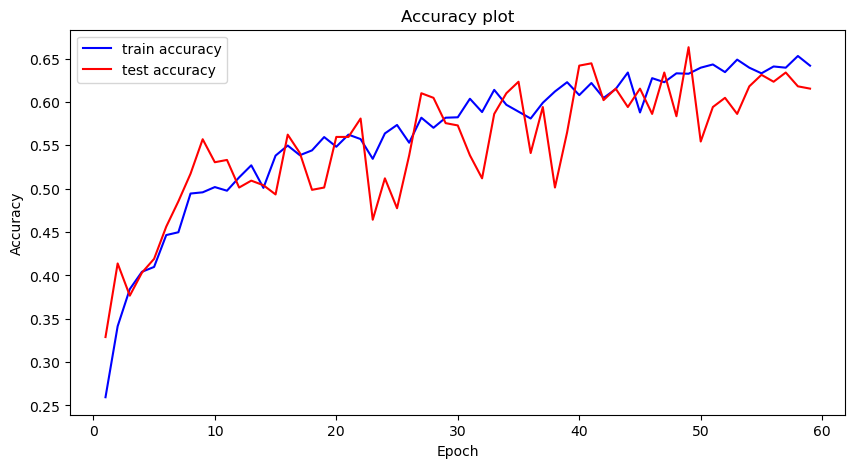

In [21]:
# Accuracy on train data :
accuracy = history.history['categorical_accuracy']

# Accuracy on test data :
val_accuracy = history.history['val_categorical_accuracy']  
epochs = range(1, len(accuracy) + 1)  # Epochs

# Accuracy line plot :
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, 'b', label='train accuracy')
plt.plot(epochs, val_accuracy, 'r', label='test accuracy')
plt.title('Accuracy plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

In [109]:
classes = train_data.class_indices
classes

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

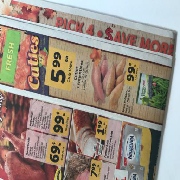

In [117]:
img = utils.load_img(
    'trash_images/paper/paper_010.jpg',
    grayscale=False,
    color_mode='rgb',
    target_size=(180, 180),
    interpolation='nearest',
    keep_aspect_ratio=False
)

img 

In [118]:
img = utils.img_to_array(img)
img = img / 255.0    # Normalize the image

result = model.predict(tf.expand_dims(img, axis=0))

classes = train_data.class_indices

for key, value in classes.items():
    if value == np.argmax(result):
        print(key)

1/1 [==============================] - 0s 26ms/step
paper


In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('/content/trash.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflmodel = converter.convert()
file = open( '/content/trashdetection.tflite' , 'wb' )
file.write( tflmodel )